In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import mpl_toolkits
import nltk
from wordcloud import WordCloud

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

***Importing the dataset***

In [2]:
yelp = pd.read_csv('yelp_dataset_final.csv', index_col = 0)

In [3]:
# Checking the shape of the data
yelp.shape

(229907, 31)

In [4]:
# generating a descriptive statistics of the dataset
yelp.describe().T

,count,mean,std,min,25%,50%,75%,max
business_latitude,229907.0,33.485976,0.109553,32.876848,33.422543,33.492985,33.538927,34.002867
business_longitude,229907.0,-111.985018,0.125656,-112.875482,-112.066300,-111.964558,-111.922262,-111.263508
business_neighborhoods,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_review_count,229907.0,113.394199,141.763461,3.000000,21.000000,64.000000,145.000000,862.000000
business_stars,229907.0,3.776120,0.594391,1.000000,3.500000,4.000000,4.000000,5.000000
cool,229907.0,0.868234,1.943242,0.000000,0.000000,0.000000,1.000000,117.000000
funny,229907.0,0.699030,1.863522,0.000000,0.000000,0.000000,1.000000,70.000000
reviewer_average_stars,229907.0,3.527542,1.066568,0.000000,3.430000,3.750000,4.020000,5.000000
reviewer_cool,229907.0,246.295415,915.875702,0.000000,2.000000,15.000000,102.000000,22410.000000
reviewer_funny,229907.0,200.039177,758.736983,0.000000,1.000000,12.000000,79.000000,24519.000000


## Cleaning of dataset

***Null value treatment***

In [5]:
null_columns=yelp.columns[yelp.isnull().any()]
yelp[null_columns].isnull().sum()

business_categories          777
business_neighborhoods    229907
reviewer_name              14028
text                           6
dtype: int64

In [6]:
# Dropping the whole 'business_neighborhoods' column
yelp.drop('business_neighborhoods', axis=1, inplace = True)

In [7]:
# Dropping the remaining rows with null values as "business_categories" column has 0.33% and "text" column has 0.002% null rows out of total

yelp.dropna(axis=0, inplace = True)

***Checking the number of unique values in each column so as to drop the unnecessary columns***

In [8]:
temp ={}
for i in yelp:
    temp[i]=len(yelp[i].unique())
temp

{'business_blank': 1,
 'business_categories': 2059,
 'business_city': 61,
 'business_full_address': 10182,
 'business_id': 11358,
 'business_latitude': 8813,
 'business_longitude': 8819,
 'business_name': 8183,
 'business_open': 2,
 'business_review_count': 293,
 'business_stars': 9,
 'business_state': 4,
 'business_type': 1,
 'cool': 52,
 'date': 2497,
 'funny': 49,
 'review_id': 215168,
 'reviewer_average_stars': 331,
 'reviewer_blank': 1,
 'reviewer_cool': 1116,
 'reviewer_funny': 1027,
 'reviewer_name': 8308,
 'reviewer_review_count': 853,
 'reviewer_type': 1,
 'reviewer_useful': 1329,
 'stars': 5,
 'text': 214944,
 'type': 1,
 'useful': 51,
 'user_id': 43762}

In [9]:
# From the above count of unique values in each column, we first drop the columns with only 1 unique value
yelp.drop(['business_blank','business_type','reviewer_blank','reviewer_type','type'],axis=1,inplace=True)

# Also if we check, there are a few more columns which does not infer any meaning and also some of them are redundant. So we drop them as well
yelp.drop(['business_name','cool', 'funny', 'reviewer_name', 'useful'],axis=1,inplace=True)

In [10]:
#checking the number of business in each state
yelp.business_state.value_counts()

AZ    215152
CA         6
CO         5
SC         5
Name: business_state, dtype: int64

In [11]:
# Here we see that except Arizona(AZ), the other 3 states just have 16 businesses in total. So we remove the other 3 cities
yelp.drop(yelp[yelp.business_state!='AZ'].index,inplace=True)

In [12]:
yelp.drop(['business_state'],axis=1,inplace=True)

In [13]:
# Checking the new shape of our data after all the data cleaning
yelp.shape

(215152, 19)

# Exploratory Data Analysis (EDA)

## Feature Engineering

***Categorizing businessess based on words present in business_categories***

In [14]:
cat = []
for x in yelp.business_categories:
    if  'pets' in x.lower():
        cat.append('Pets')
    elif  'religious' in x.lower():
        cat.append('Religious Org')
    elif  'school' in x.lower() or 'university' in x.lower() or 'education' in x.lower():
        cat.append('Education')
    elif  'gym' in x.lower() or 'fitness' in x.lower() or 'yoga' in x.lower():
        cat.append('Fitness')
    elif  'bars' in x.lower() or 'nightlife' in x.lower() or 'entertainment' in x.lower() or 'beer' in x.lower():
        cat.append('Bars')
    elif 'restaurants' in x.lower() or'smoothies' in x.lower() or'bakeries' in x.lower() or'coffee' in x.lower():
        cat.append('Restaurant')
    elif  'clothing' in x.lower() or'shopping' in x.lower() or'grocery' in x.lower() or 'store' in x.lower():
        cat. append('Shopping')
    elif 'automotive' in x.lower():
        cat.append('Automotive')
    elif 'spa' in x.lower():
        cat.append('Spa')
    elif 'service' in x.lower():
        cat.append('Service')
    elif 'parks' in x.lower() or  'lakes' in x.lower() or 'zoo' in x.lower() or 'pools' in x.lower():
        cat.append('Parks')
    elif 'travel' in x.lower():
        cat.append('Travel')
    elif 'Medical' in x.lower() or 'health' in x.lower():
        cat.append('Medical')
    elif 'food' in x.lower():
        cat.append('Other Foods')
    elif 'active life' in x.lower():
        cat.append('Active Life')
    
    else:
        cat.append('Others')

In [15]:
# Assigning Cateegories to new Column
yelp['new_categories'] = cat
yelp[['business_categories','new_categories']].head(10)

,business_categories,new_categories
0,Breakfast & Brunch; Restaurants,Restaurant
1,Italian; Pizza; Restaurants,Restaurant
2,Middle Eastern; Restaurants,Restaurant
3,Active Life; Dog Parks; Parks,Parks
4,Tires; Automotive,Automotive
5,Wine Bars; Bars; American (New); Nightlife; Re...,Bars
6,Mexican; Restaurants,Restaurant
7,Hotels & Travel; Airports,Travel
8,Sushi Bars; Restaurants,Bars
9,Food; Tea Rooms; Japanese; Restaurants,Restaurant


***Classifying reviewers by creating 5 bins based on reviewer_review_count***

In [16]:
listn=[]
for i in yelp.reviewer_review_count:
    if i <= 100:
        listn.append('1')
    elif i <= 200:
        listn.append('2')
    elif i <= 300:
        listn.append('3')
    elif i <= 400:
        listn.append('4')
    else:
        listn.append('5')

In [17]:
yelp['class_of_reviewer'] = listn
yelp[['user_id','reviewer_review_count','class_of_reviewer']].head()

,user_id,reviewer_review_count,class_of_reviewer
0,rLtl8ZkDX5vH5nAx9C3q5Q,376,4
1,0a2KyEL0d3Yb1V6aivbIuQ,2,1
2,0hT2KtfLiobPvh6cDC8JQg,3,1
3,uZetl9T0NcROGOyFfughhg,31,1
4,vYmM4KTsC8ZfQBg-j5MWkw,28,1


In [18]:
listwt=[]
for i in yelp.class_of_reviewer:
    if i == str(1):
        listwt.append('1.2')
    elif i == str(2):
        listwt.append('1.4')
    elif i == str(3):
        listwt.append('1.6')
    elif i ==str(4):
        listwt.append('1.8')
    else:
        listwt.append('2.0')

In [19]:
yelp['weight'] = listwt

In [20]:
yelp.weight = yelp.weight.astype('float64')

In [21]:
# Creating the new attribute to describe the quality of a reviewer

yelp['reviewer_score'] = yelp.reviewer_average_stars*yelp.weight

In [22]:
yelp[['user_id','reviewer_review_count','reviewer_average_stars','class_of_reviewer','weight','reviewer_score']].head(12)

,user_id,reviewer_review_count,reviewer_average_stars,class_of_reviewer,weight,reviewer_score
0,rLtl8ZkDX5vH5nAx9C3q5Q,376,3.72,4,1.8,6.696
1,0a2KyEL0d3Yb1V6aivbIuQ,2,5.00,1,1.2,6.000
2,0hT2KtfLiobPvh6cDC8JQg,3,4.33,1,1.2,5.196
3,uZetl9T0NcROGOyFfughhg,31,4.29,1,1.2,5.148
4,vYmM4KTsC8ZfQBg-j5MWkw,28,3.25,1,1.2,3.900
5,sqYN3lNgvPbPCTRsMFu27g,654,3.54,5,2.0,7.080
6,wFweIWhv2fREZV_dYkz_1g,295,3.79,3,1.6,6.064
7,1ieuYcKS7zeAv_U15AB13A,173,3.42,2,1.4,4.788
8,Vh_DlizgGhSqQh4qfZ2h6A,18,3.56,1,1.2,4.272
9,sUNkXg8-KFtCMQDV6zRzQg,6,4.17,1,1.2,5.004


In [23]:
yelp.groupby('user_id')['reviewer_average_stars','reviewer_review_count','reviewer_score'].mean().sort_values(by='reviewer_score',ascending=False)[:20]

,reviewer_average_stars,reviewer_review_count,reviewer_score
user_id,,,
Dt2JQ62K6Gh59rUEfvhMCQ,4.71,670,9.42
u5bvcT_3Go0O3Xk4Am8CWQ,4.44,719,8.88
ZqhjX-lmC7UKR_e1AAz64w,4.44,735,8.88
TeyGu-fF6IN7IUpVVI76FA,4.39,422,8.78
55GXsFLH4QYnTQqiijBtxA,4.38,967,8.76
rjsx6_pSqwl0zuiwa_tI2g,4.37,590,8.74
Vbcz3s9CRXlaJWcDOI9XzQ,4.37,569,8.74
YyavHs3U4XaX9shLcUV6bA,4.36,470,8.72
qFHOh1DMqJ2Zb_pvqR1Muw,4.35,643,8.70


***Classifying reviewer stars into 2 classes as 'satisfied' if review stars are more than 4 and 'dissatisfied' if review stars less than 3***

***dissatisfied labelled as 0 and satisfied labelled as 1***

In [24]:
liststar=[]
for i in yelp.stars:
    if i <= 3:
        liststar.append('0')    # 0 indicates dissatisfied 
    else:
        liststar.append('1')    # 1 indicates ssatisfied

In [25]:
yelp['customer_satisfaction_level'] = liststar

## preparing model using attributes other than text

In [26]:
yelp_structured = yelp[['business_city', 'business_review_count', 'business_stars', 
                             'reviewer_cool', 'reviewer_funny','reviewer_review_count', 'reviewer_useful',
                             'new_categories','customer_satisfaction_level','reviewer_score']]
yelp_structured.head()

,business_city,business_review_count,business_stars,reviewer_cool,reviewer_funny,reviewer_review_count,reviewer_useful,new_categories,customer_satisfaction_level,reviewer_score
0,Phoenix,116,4.0,322,331,376,1034,Restaurant,1,6.696
1,Phoenix,102,4.0,0,2,2,0,Restaurant,1,6.000
2,Tempe,265,4.5,0,0,3,3,Restaurant,1,5.196
3,Scottsdale,88,4.5,36,18,31,75,Parks,1,5.148
4,Mesa,5,4.5,8,3,28,32,Automotive,1,3.900


In [27]:
yelp_structured.shape

(215152, 10)

In [29]:
yelp_structured.customer_satisfaction_level = yelp_structured.customer_satisfaction_level.astype('int64')

C:\Users\DEBASHIS\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [30]:
yelp_structured.customer_satisfaction_level.dtype

dtype('int64')

In [31]:
yelp_structured_dummies = pd.get_dummies(yelp_structured, drop_first=True)

In [32]:
yelp_structured_dummies.shape

(215152, 81)

In [33]:
yelp_structured.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215152 entries, 0 to 229906
Data columns (total 10 columns):
business_city                  215152 non-null object
business_review_count          215152 non-null int64
business_stars                 215152 non-null float64
reviewer_cool                  215152 non-null int64
reviewer_funny                 215152 non-null int64
reviewer_review_count          215152 non-null int64
reviewer_useful                215152 non-null int64
new_categories                 215152 non-null object
customer_satisfaction_level    215152 non-null int64
reviewer_score                 215152 non-null float64
dtypes: float64(2), int64(6), object(2)
memory usage: 18.1+ MB


##### Heatmap

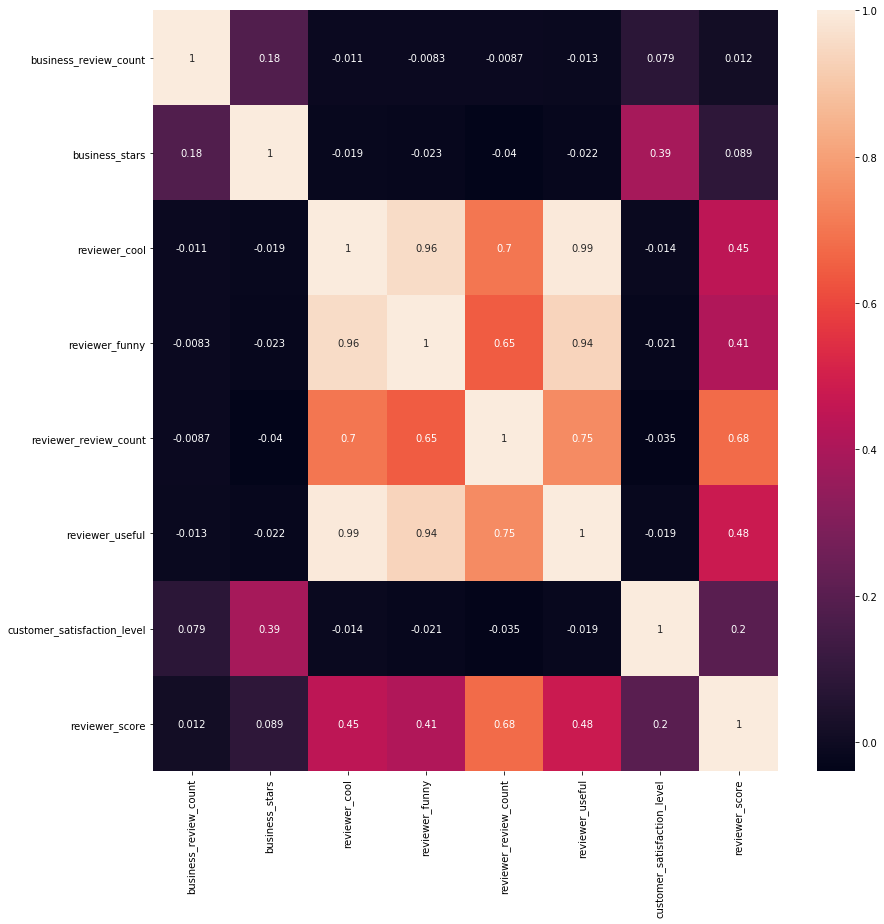

In [34]:
plt.figure(figsize=(14,14))
sns.heatmap(yelp_structured.corr(), annot=True)
plt.show()

In [35]:
yelp_structured.corr()

,business_review_count,business_stars,reviewer_cool,reviewer_funny,reviewer_review_count,reviewer_useful,customer_satisfaction_level,reviewer_score
business_review_count,1.000000,0.181863,-0.010830,-0.008288,-0.008687,-0.012978,0.078851,0.012467
business_stars,0.181863,1.000000,-0.018964,-0.023301,-0.039731,-0.021660,0.388106,0.089320
reviewer_cool,-0.010830,-0.018964,1.000000,0.956003,0.703063,0.992421,-0.014316,0.445259
reviewer_funny,-0.008288,-0.023301,0.956003,1.000000,0.645637,0.936612,-0.020557,0.413698
reviewer_review_count,-0.008687,-0.039731,0.703063,0.645637,1.000000,0.751867,-0.035290,0.675573
reviewer_useful,-0.012978,-0.021660,0.992421,0.936612,0.751867,1.000000,-0.018735,0.479428
customer_satisfaction_level,0.078851,0.388106,-0.014316,-0.020557,-0.035290,-0.018735,1.000000,0.202480
reviewer_score,0.012467,0.089320,0.445259,0.413698,0.675573,0.479428,0.202480,1.000000


### Building data for model

In [36]:
X = yelp_structured_dummies.drop(['customer_satisfaction_level'],axis=1)
y = yelp_structured_dummies['customer_satisfaction_level']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

### Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(X_train, y_train)

C:\Users\DEBASHIS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DEBASHIS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
preds = lr.predict(X_test)

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [42]:
def confusion_matrix(actual, predicted):
    cm = metrics.confusion_matrix(actual, predicted, [0,1])
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels = ['0', '1'], yticklabels = ['0', '1'], cmap = 'Greens')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('CONFUSION MATRIX')
    plt.show()
    
def performance_measures(actual, predicted):
    cm = metrics.confusion_matrix(actual, predicted, [0,1])
    
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print('Accuracy    : ', ACC)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print('Precision   : ', PPV)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print('Sensitivity : ', TPR)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print('Specificity : ', TNR)
   
        
def classification_summary(acutal, predicted):
    # Classification Report
    print(classification_report(y_test, preds))

In [43]:
print('Training     : ',lr.score(X_train,y_train))
print('Testing      : ',lr.score(X_test,y_test))

Training     :  0.7532369228317597
Testing      :  0.7511077371177145


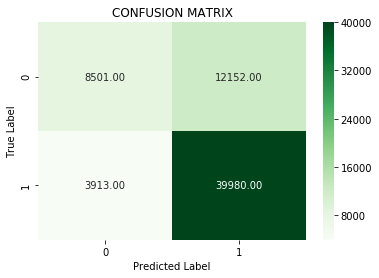

In [44]:
confusion_matrix(y_test, preds)

In [45]:
performance_measures(y_test, preds)

Accuracy    :  [0.75110774 0.75110774]
Precision   :  [0.68479136 0.76689941]
Sensitivity :  [0.4116109  0.91085139]
Specificity :  [0.91085139 0.4116109 ]


In [46]:
classification_summary(y_test, preds)

              precision    recall  f1-score   support

           0       0.68      0.41      0.51     20653
           1       0.77      0.91      0.83     43893

   micro avg       0.75      0.75      0.75     64546
   macro avg       0.73      0.66      0.67     64546
weighted avg       0.74      0.75      0.73     64546



In [47]:
#Build the logistic regression model
import statsmodels.api as sm
from statsmodels.api import add_constant

X2 = add_constant(X_train)
#X2.drop(['business_open'], axis=1, inplace=True)
logit = sm.Logit(y_train, X2)
lg = logit.fit(method='bfgs')

C:\Users\DEBASHIS\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\DEBASHIS\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.510877
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 41


C:\Users\DEBASHIS\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [48]:
#Summary of logistic regression
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
print(lg.summary())

                                Logit Regression Results                               
Dep. Variable:     customer_satisfaction_level   No. Observations:               150606
Model:                                   Logit   Df Residuals:                   150526
Method:                                    MLE   Df Model:                           79
Date:                         Wed, 03 Apr 2019   Pseudo R-squ.:                  0.1825
Time:                                 11:22:31   Log-Likelihood:                -76941.
converged:                               False   LL-Null:                       -94116.
                                                 LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -6.4521      0.360    -17.902      0.000      -7.158      -5.746

In [49]:
#Calculate Odds Ratio

lgcoef = pd.DataFrame(lg.params, columns=['coef'])
lgcoef.loc[:, "Odds_ratio"] = np.exp(lgcoef.coef)
pd.options.display.float_format = '{:.2f}'.format
lgcoef['p-values'] = lg.pvalues
lgcoef

,coef,Odds_ratio,p-values
const,-6.45,0.00,0.00
business_review_count,0.00,1.00,0.00
business_stars,1.39,4.00,0.00
reviewer_cool,0.00,1.00,0.00
reviewer_funny,-0.00,1.00,0.00
reviewer_review_count,-0.00,1.00,0.00
reviewer_useful,-0.00,1.00,0.00
reviewer_score,0.84,2.32,0.00
business_city_Anthem,-0.01,0.99,0.98
business_city_Apache Junction,-0.01,0.99,0.97


In [50]:
lgcoef[lgcoef['p-values'] < 0.05]

,coef,Odds_ratio,p-values
const,-6.45,0.00,0.00
business_review_count,0.00,1.00,0.00
business_stars,1.39,4.00,0.00
reviewer_cool,0.00,1.00,0.00
reviewer_funny,-0.00,1.00,0.00
reviewer_review_count,-0.00,1.00,0.00
reviewer_useful,-0.00,1.00,0.00
reviewer_score,0.84,2.32,0.00
business_city_Chandler,-0.76,0.47,0.02
business_city_Glendale,-0.75,0.47,0.02


In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


X=yelp_structured_dummies
vif = pd.DataFrame()
vif["features"] =X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [52]:
vif[vif['VIF Factor']<5]

,features,VIF Factor
0,business_review_count,2.10
6,customer_satisfaction_level,3.99
8,business_city_Anthem,1.42
9,business_city_Apache Junction,1.29
10,business_city_Avondale,2.54
11,business_city_Buckeye,1.24
12,business_city_Carefree,1.31
13,business_city_Casa Grande,1.35
14,business_city_Cave Creek,1.90
16,business_city_Coolidge,1.04


***Random Forest***

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
preds_rf = rf.predict(X_test)

In [56]:
print('Training     : ',rf.score(X_train,y_train))
print('Testing      : ',rf.score(X_test,y_test))

Training     :  0.9980213271715602
Testing      :  0.7365289870789824


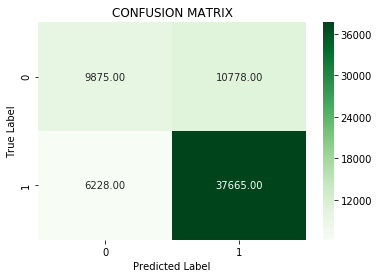

In [57]:
confusion_matrix(y_test, preds_rf)

In [58]:
performance_measures(y_test, preds_rf)

Accuracy    :  [0.73652899 0.73652899]
Precision   :  [0.61323977 0.77751171]
Sensitivity :  [0.47813877 0.85810949]
Specificity :  [0.85810949 0.47813877]


In [59]:
classification_summary(y_test, preds_rf)

              precision    recall  f1-score   support

           0       0.68      0.41      0.51     20653
           1       0.77      0.91      0.83     43893

   micro avg       0.75      0.75      0.75     64546
   macro avg       0.73      0.66      0.67     64546
weighted avg       0.74      0.75      0.73     64546



In [64]:
rf_imp = pd.DataFrame(rf.feature_importances_,columns = ['Importance'], index = X_train.columns)
rf_imp.reset_index(inplace = True)
rf_imp

,index,Importance
0,business_review_count,0.20
1,business_stars,0.14
2,reviewer_cool,0.09
3,reviewer_funny,0.09
4,reviewer_review_count,0.11
5,reviewer_useful,0.10
6,reviewer_score,0.19
7,business_city_Anthem,0.00
8,business_city_Apache Junction,0.00
9,business_city_Avondale,0.00


In [75]:
rf_imp = pd.DataFrame(rf_imp.groupby('index')['Importance'].mean().sort_values(ascending=False)[:20])
rf_imp.reset_index(inplace=True)
rf_imp

,index,Importance
0,business_review_count,0.20
1,reviewer_score,0.19
2,business_stars,0.14
3,reviewer_review_count,0.11
4,reviewer_useful,0.10
5,reviewer_cool,0.09
6,reviewer_funny,0.09
7,business_city_Phoenix,0.01
8,business_city_Scottsdale,0.01
9,new_categories_Restaurant,0.01


In [76]:
rf_imp.to_excel('rf_imp.xlsx')

## Text Preprocessing

In [61]:
# Libraries for text preprocessing
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer 

In [62]:
# Remove Punctuation
yelp['review_nopunc'] = yelp['text'].str.replace('[^a-zA-Z ]', '')
yelp[['text','review_nopunc']].head()

,text,review_nopunc
0,My wife took me here on my birthday for breakf...,My wife took me here on my birthday for breakf...
1,I have no idea why some people give bad review...,I have no idea why some people give bad review...
2,love the gyro plate. Rice is so good and I als...,love the gyro plate Rice is so good and I also...
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",Rosie Dakota and I LOVE Chaparral Dog Park Its...
4,General Manager Scott Petello is a good egg!!!...,General Manager Scott Petello is a good egg No...


In [63]:
# Lower case all words
yelp['review_lower'] = yelp['review_nopunc'].apply(lambda x: " ".join(x.lower() for x in x.split()))
yelp[['text','review_nopunc','review_lower']].head()

,text,review_nopunc,review_lower
0,My wife took me here on my birthday for breakf...,My wife took me here on my birthday for breakf...,my wife took me here on my birthday for breakf...
1,I have no idea why some people give bad review...,I have no idea why some people give bad review...,i have no idea why some people give bad review...
2,love the gyro plate. Rice is so good and I als...,love the gyro plate Rice is so good and I also...,love the gyro plate rice is so good and i also...
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",Rosie Dakota and I LOVE Chaparral Dog Park Its...,rosie dakota and i love chaparral dog park its...
4,General Manager Scott Petello is a good egg!!!...,General Manager Scott Petello is a good egg No...,general manager scott petello is a good egg no...


In [64]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))


# Identify top 50 common words
freq = pd.Series(' '.join(yelp['review_lower']).split()).value_counts()[:50]
stop_words = stop_words.union(freq)

In [65]:
len(stop_words)

229

In [66]:
##Creating a list of custom stopwords
new_words = ['place','food','restaurant','went','one','go','really',\
                   'would','service','also',"i'm","i've",'us','ordered','eaten','maybe'\
                   'much','get', 'us', 'see', 'use', 'said', 'asked', 'day', 'go', \
                   'even', 'im', 'right', 'left', 'always', 'would', 'told','took','try ' \
                   'get', 'us', 'would', 'get', 'one', 'ive', 'go', 'even', 'got ' \
                   'also', 'ever', 'x', 'take', 'let','goes','','friend','',''\
                   'phoenix', 'wife', 'bar','review','month','','give','','show'\
                   'people','year','two','saturday','star','review','id']
stop_words = stop_words.union(new_words)

In [67]:
len(stop_words)

280

In [68]:
# removing  custom stopwords and top 50 common words
yelp['review_nopunc_nostop'] = yelp['review_lower'].apply(lambda x: "".join(" ".join(y for y in x.split() if y not in stop_words)))
yelp[['text','review_nopunc','review_lower','review_nopunc_nostop']].head()

,text,review_nopunc,review_lower,review_nopunc_nostop
0,My wife took me here on my birthday for breakf...,My wife took me here on my birthday for breakf...,my wife took me here on my birthday for breakf...,birthday breakfast excellent weather perfect m...
1,I have no idea why some people give bad review...,I have no idea why some people give bad review...,i have no idea why some people give bad review...,idea people bad reviews show please everyone p...
2,love the gyro plate. Rice is so good and I als...,love the gyro plate Rice is so good and I also...,love the gyro plate rice is so good and i also...,love gyro plate rice good dig candy selection
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",Rosie Dakota and I LOVE Chaparral Dog Park Its...,rosie dakota and i love chaparral dog park its...,rosie dakota love chaparral dog park convenien...
4,General Manager Scott Petello is a good egg!!!...,General Manager Scott Petello is a good egg No...,general manager scott petello is a good egg no...,general manager scott petello good egg detail ...


***Lemmatization***

In [69]:
from textblob import Word
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DEBASHIS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [70]:
yelp['cleaned_review'] = yelp['review_nopunc_nostop'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
yelp.head()

,business_categories,business_city,business_full_address,business_id,business_latitude,business_longitude,business_open,business_review_count,business_stars,date,...,user_id,new_categories,class_of_reviewer,weight,reviewer_score,customer_satisfaction_level,review_nopunc,review_lower,review_nopunc_nostop,cleaned_review
0,Breakfast & Brunch; Restaurants,Phoenix,"6106 S 32nd St\nPhoenix, AZ 85042",9yKzy9PApeiPPOUJEtnvkg,33.39,-112.01,True,116,4.00,2011-01-26,...,rLtl8ZkDX5vH5nAx9C3q5Q,Restaurant,4,1.80,6.70,1,My wife took me here on my birthday for breakf...,my wife took me here on my birthday for breakf...,birthday breakfast excellent weather perfect m...,birthday breakfast excellent weather perfect m...
1,Italian; Pizza; Restaurants,Phoenix,"4848 E Chandler Blvd\nPhoenix, AZ 85044",ZRJwVLyzEJq1VAihDhYiow,33.31,-111.98,True,102,4.00,2011-07-27,...,0a2KyEL0d3Yb1V6aivbIuQ,Restaurant,1,1.20,6.00,1,I have no idea why some people give bad review...,i have no idea why some people give bad review...,idea people bad reviews show please everyone p...,idea people bad review show please everyone pr...
2,Middle Eastern; Restaurants,Tempe,"1513 E Apache Blvd\nTempe, AZ 85281",6oRAC4uyJCsJl1X0WZpVSA,33.41,-111.91,True,265,4.50,2012-06-14,...,0hT2KtfLiobPvh6cDC8JQg,Restaurant,1,1.20,5.20,1,love the gyro plate Rice is so good and I also...,love the gyro plate rice is so good and i also...,love gyro plate rice good dig candy selection,love gyro plate rice good dig candy selection
3,Active Life; Dog Parks; Parks,Scottsdale,"5401 N Hayden Rd\nScottsdale, AZ 85250",_1QQZuf4zZOyFCvXc0o6Vg,33.52,-111.91,True,88,4.50,2010-05-27,...,uZetl9T0NcROGOyFfughhg,Parks,1,1.20,5.15,1,Rosie Dakota and I LOVE Chaparral Dog Park Its...,rosie dakota and i love chaparral dog park its...,rosie dakota love chaparral dog park convenien...,rosie dakota love chaparral dog park convenien...
4,Tires; Automotive,Mesa,"1357 S Power Road\nMesa, AZ 85206",6ozycU1RpktNG2-1BroVtw,33.39,-111.68,True,5,4.50,2012-01-05,...,vYmM4KTsC8ZfQBg-j5MWkw,Automotive,1,1.20,3.90,1,General Manager Scott Petello is a good egg No...,general manager scott petello is a good egg no...,general manager scott petello good egg detail ...,general manager scott petello good egg detail ...


In [71]:
print('Base Review\n\n', yelp['text'][0])
print('\n-------------------------------------------------------------------------------------------------------------------\n')
print('Cleaned and Lemmatized Review \n\n', yelp['cleaned_review'][0])

Base Review

 My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!

-----------------------------------------------------------------------------------------------

# Modelling

In [72]:
yelp.customer_satisfaction_level.value_counts()

1    146692
0     68460
Name: customer_satisfaction_level, dtype: int64

In [73]:
x = yelp['cleaned_review']
y = yelp['customer_satisfaction_level']

### BOW and Modelling for LR with 100 features

In [74]:
yelp.customer_satisfaction_level = yelp.customer_satisfaction_level.astype('int64')

In [75]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=100, ngram_range=(1,3)).fit(x)
X = cv.transform(x)
y = yelp['customer_satisfaction_level']

In [76]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (215152, 100)
Amount of Non-Zero occurrences:  2473085
Density: 11.494594519223618


In [77]:
dtm_matrix=X.toarray()
df_dtm=pd.DataFrame(dtm_matrix,columns=cv.get_feature_names())
df_dtm.head()

,amazing,another,area,around,awesome,back,bad,beer,best,better,...,think,though,time,try,wait,want,wasnt,way,well,work
0,1,0,0,0,0,1,0,0,2,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,1,3,0,0,2,...,0,0,0,2,1,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
df_dtm.shape

(215152, 100)

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_dtm, y, test_size=0.3, random_state=100)

***Logistic Regression model***

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(X_train, y_train)

C:\Users\DEBASHIS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DEBASHIS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
preds = lr.predict(X_test)

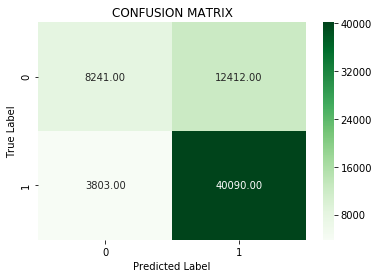

In [83]:
confusion_matrix(y_test, preds)

In [84]:
performance_measures(y_test, preds)

Accuracy    :  [0.74878381 0.74878381]
Precision   :  [0.68424112 0.76358996]
Sensitivity :  [0.39902193 0.91335748]
Specificity :  [0.91335748 0.39902193]


In [85]:
classification_summary(y_test, preds)

              precision    recall  f1-score   support

           0       0.68      0.40      0.50     20653
           1       0.76      0.91      0.83     43893

   micro avg       0.75      0.75      0.75     64546
   macro avg       0.72      0.66      0.67     64546
weighted avg       0.74      0.75      0.73     64546



In [86]:
print('Training     : ',lr.score(X_train,y_train))
print('Testing      : ',lr.score(X_test,y_test))

Training     :  0.7504083502649297
Testing      :  0.7487838130945372


In [87]:
y_train = list(y_train)

In [88]:
#Build the logistic regression model
import statsmodels.api as sm

logit = sm.Logit(y_train, sm.add_constant(X_train))
lg = logit.fit()

Optimization terminated successfully.
         Current function value: 0.503663
         Iterations 7


In [89]:
#Summary of logistic regression
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               150606
Model:                          Logit   Df Residuals:                   150505
Method:                           MLE   Df Model:                          100
Date:                Sat, 30 Mar 2019   Pseudo R-squ.:                  0.1940
Time:                        16:39:14   Log-Likelihood:                -75855.
converged:                       True   LL-Null:                       -94116.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5219      0.011     49.125      0.000       0.501       0.543
amazing        0.9975      0.027     37.027      0.000       0.945       1.050
another       -0.3359      0.020    -16.554      0.0

In [90]:
#Calculate Odds Ratio

lgcoef = pd.DataFrame(lg.params, columns=['coef'])
lgcoef.loc[:, "Odds_ratio"] = np.exp(lgcoef.coef)
pd.options.display.float_format = '{:.2f}'.format
lgcoef['p-values'] = lg.pvalues
lgcoef

,coef,Odds_ratio,p-values
const,0.52,1.69,0.00
amazing,1.00,2.71,0.00
another,-0.34,0.71,0.00
area,0.06,1.06,0.00
around,0.03,1.03,0.07
awesome,0.94,2.55,0.00
back,-0.11,0.90,0.00
bad,-0.72,0.49,0.00
beer,-0.01,0.99,0.63
best,0.60,1.82,0.00


### Ma'am given code for BOW

In [91]:
yelp.customer_satisfaction_level = yelp.customer_satisfaction_level.astype('int64')

In [92]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=2000, ngram_range=(1,3)).fit(x)
X = cv.transform(x)
y = yelp['customer_satisfaction_level']

In [93]:
len(cv.vocabulary_)

2000

In [94]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (215152, 2000)
Amount of Non-Zero occurrences:  8431464
Density: 1.959420316799286


In [97]:
dtm_matrix=X.toarray()
df_dtm=pd.DataFrame(dtm_matrix,columns=cv.get_feature_names())
df_dtm.head()

,able,absolute,absolutely,ac,accommodating,across,across street,act,actual,actually,...,york,youd,youll,young,youre,youre going,youre looking,youve,yum,yummy
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Training data and test data

In [98]:
df_dtm.shape

(215152, 2000)

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_dtm, y, test_size=0.3, random_state=100)

### Modelling using reviewer text

***Decision Tree***

In [100]:
from sklearn.tree import DecisionTreeClassifier

In [101]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [102]:
preds_dt = dt.predict(X_test)

In [103]:
print('Training     : ',dt.score(X_train,y_train))
print('Testing      : ',dt.score(X_test,y_test))

Training     :  0.9991766596284345
Testing      :  0.7284107458246831


In [104]:
type(y_test)

pandas.core.series.Series

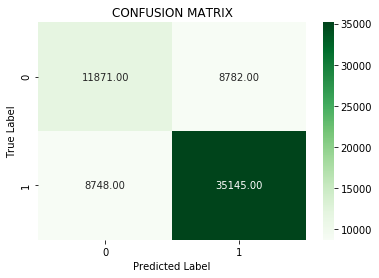

In [105]:
confusion_matrix(y_test, preds_dt)

In [106]:
performance_measures(y_test, preds_dt)

Accuracy    :  [0.72841075 0.72841075]
Precision   :  [0.57573112 0.8000774 ]
Sensitivity :  [0.57478332 0.80069715]
Specificity :  [0.80069715 0.57478332]


In [107]:
classification_summary(y_test, preds_dt)

              precision    recall  f1-score   support

           0       0.68      0.40      0.50     20653
           1       0.76      0.91      0.83     43893

   micro avg       0.75      0.75      0.75     64546
   macro avg       0.72      0.66      0.67     64546
weighted avg       0.74      0.75      0.73     64546



In [108]:
pd.DataFrame(dt.feature_importances_,columns = ['Importance'], index = X_train.columns)

,Importance
able,0.00
absolute,0.00
absolutely,0.00
ac,0.00
accommodating,0.00
across,0.00
across street,0.00
act,0.00
actual,0.00
actually,0.00


***Random Forest***

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

C:\Users\DEBASHIS\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [111]:
preds_rf = rf.predict(X_test)

In [112]:
print('Training     : ',rf.score(X_train,y_train))
print('Testing      : ',rf.score(X_test,y_test))

Training     :  0.9920985883696533
Testing      :  0.7835497164812691


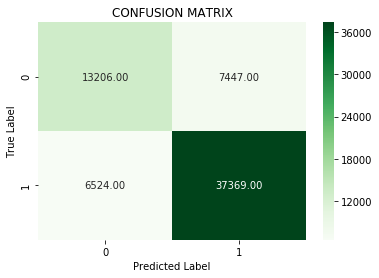

In [113]:
confusion_matrix(y_test, preds_rf)

In [114]:
performance_measures(y_test, preds_rf)

Accuracy    :  [0.78354972 0.78354972]
Precision   :  [0.66933604 0.83383167]
Sensitivity :  [0.63942284 0.85136582]
Specificity :  [0.85136582 0.63942284]


In [115]:
classification_summary(y_test, preds_rf)

              precision    recall  f1-score   support

           0       0.68      0.40      0.50     20653
           1       0.76      0.91      0.83     43893

   micro avg       0.75      0.75      0.75     64546
   macro avg       0.72      0.66      0.67     64546
weighted avg       0.74      0.75      0.73     64546



In [116]:
pd.DataFrame(rf.feature_importances_,columns = ['Importance'], index = X_train.columns)

,Importance
able,0.00
absolute,0.00
absolutely,0.00
ac,0.00
accommodating,0.00
across,0.00
across street,0.00
act,0.00
actual,0.00
actually,0.00


***Naive Bayes***

In [117]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [118]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [119]:
preds_gnb = gnb.predict(X_test)

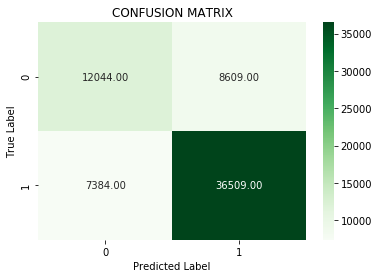

In [120]:
confusion_matrix(y_test, preds_gnb)

In [121]:
performance_measures(y_test, preds_gnb)

Accuracy    :  [0.75222322 0.75222322]
Precision   :  [0.61993    0.80918924]
Sensitivity :  [0.58315983 0.83177272]
Specificity :  [0.83177272 0.58315983]


In [122]:
classification_summary(y_test, preds_gnb)

              precision    recall  f1-score   support

           0       0.68      0.40      0.50     20653
           1       0.76      0.91      0.83     43893

   micro avg       0.75      0.75      0.75     64546
   macro avg       0.72      0.66      0.67     64546
weighted avg       0.74      0.75      0.73     64546



In [123]:
print('Training     : ',gnb.score(X_train,y_train))
print('Testing      : ',gnb.score(X_test,y_test))

Training     :  0.7549168027834217
Testing      :  0.7522232206488396


***Multinomial Naive Bayes***

In [124]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [125]:
preds_mnb = mnb.predict(X_test)

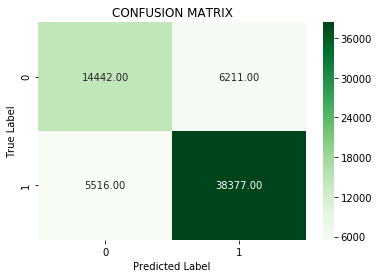

In [126]:
confusion_matrix(y_test, preds_mnb)

In [127]:
performance_measures(y_test, preds_mnb)

Accuracy    :  [0.81831562 0.81831562]
Precision   :  [0.7236196  0.86070243]
Sensitivity :  [0.69926887 0.87433076]
Specificity :  [0.87433076 0.69926887]


In [128]:
classification_summary(y_test, preds_mnb)

              precision    recall  f1-score   support

           0       0.68      0.40      0.50     20653
           1       0.76      0.91      0.83     43893

   micro avg       0.75      0.75      0.75     64546
   macro avg       0.72      0.66      0.67     64546
weighted avg       0.74      0.75      0.73     64546



In [129]:
print('Training     : ',mnb.score(X_train,y_train))
print('Testing      : ',mnb.score(X_test,y_test))

Training     :  0.8216737712972922
Testing      :  0.8183156198680012
